# **Problem Statement: **Implement Dyna-Q and reproduce the blocking maze and shortcut maze experiments (see page 135, 136 in Sutton & Barto) in Pycolab.

## Dyna-Q is an architecture which integrates different modules needed while planning an agent on-line. It provides a platform to integrate learning, planning and acting.

**Installing Pycolab and Gym for our work**

In [53]:
! pip install git+https://github.com/deepmind/pycolab.git
! pip install git+https://github.com/openai/gym.git

  Cloning https://github.com/deepmind/pycolab.git to /tmp/pip-AKfsmE-build
  Cloning https://github.com/openai/gym.git to /tmp/pip-6gSLlr-build


# Pycolab Maze Environment with a Gym Wrapper

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import curses
import sys
import gym

from pycolab import ascii_art
from pycolab import human_ui
from pycolab.prefab_parts import sprites as prefab_sprites

class PlayerSprite(prefab_sprites.MazeWalker):
  """A `Sprite` for our player.

  This `Sprite` ties actions to going in the four cardinal directions. If we
  reach the goal state (0,8), the agent receives a
  reward of 1 and the epsiode terminates.
  """

  def __init__(self, corner, position, character):
    """Inform superclass that we can't walk through walls."""
    super(PlayerSprite, self).__init__(
        corner, position, character, impassable='#', confined_to_board=True)

  def update(self, actions, board, layers, backdrop, things, the_plot):
    del layers, backdrop, things   # Unused.

    # Apply motion commands.
    if actions == 0:    # walk upward?
      self._north(board, the_plot)
    elif actions == 1:  # walk downward?
      self._south(board, the_plot)
    elif actions == 2:  # walk leftward?
      self._west(board, the_plot)
    elif actions == 3:  # walk rightward?
      self._east(board, the_plot)

 #   # See if we've found the mystery spot.
    if self.position == (0, 8):
      the_plot.add_reward(1)
      the_plot.terminate_episode()
    else:
      the_plot.add_reward(0)
      

# The game art for the case where 
# the path on the left is open. 
LEFT_OPEN_GAME_ART = \
           ['        G',
            '         ',
            '         ',
            ' ########',
            '         ',
            '   P     ']


# The game art for the case where 
# the path on the right is open. 
RIGHT_OPEN_GAME_ART = \
           ['        G',
            '         ',
            '         ',
            '######## ',
            '         ',
            '   P     ']
        

# The game art for the case where the path
# on both the right and left are open. 
BOTH_OPEN_GAME_ART = \
           ['        G',
            '         ',
            '         ',
            ' ####### ',
            '         ',
            '   P     ']
      
    
def get_game_art(type):
  """ Return game art based on type.
      
      Args:
        type: Type of game art. 
              left => left open.
              right => right open.
              both => both left and right open.
     
     Returns:
        The game art based on type.
        
     Raises:
        ValueError if value not in ('left','right', 'both').
  """
  if type == 'left':
    return LEFT_OPEN_GAME_ART
  if type == 'right':
    return RIGHT_OPEN_GAME_ART
  if type == 'both':
    return BOTH_OPEN_GAME_ART
  raise ValueError("type must be one of ['left','right', 'both']. Given: " + type)
  
    
class BlockedMaze(gym.Env):
  """ Gym wrapper around BlockedMaze environment constructed in pycolab.  
  """
  def __init__(self, game_type):
    """ Init BlockedMaze environment.
    
        Args:
          game_type: Possible values ("left", "right", "both").
    """
    self.game_type = game_type
    self.game= ascii_art.ascii_art_to_game(
                  get_game_art(game_type), what_lies_beneath=' ',
                  sprites={'P': PlayerSprite})
    self.action_space = range(4)
    self.observation_space = range(54)
    obs, reward, gamma = self.game.its_showtime()
    self.inital_obs = obs
  
  def step(self, action):
    """ Take given action and return the next state observation and reward.
    """
    obs, reward, gamma = self.game.play(action)
    return obs, reward, self.game.game_over, ""
  
  def reset(self):
    """ Resets the game and returns the observation for the start state.
    """
    self.game= ascii_art.ascii_art_to_game(
                  get_game_art(self.game_type), what_lies_beneath=' ',
                  sprites={'P': PlayerSprite})
    obs, reward, gamma = self.game.its_showtime()
    self.intial_obs = obs
    return obs

def obsv2state(obs):
  """ Convert pycolab's observation to int state. 
      The state is flattened in our case and is (0,54).
  
      Args:
        obs: Pycolab's Observation object. 
        
      Returns:
        Integer state from (0,54). 
  """
  state = np.array(obs.layers['P'], dtype=np.float).flatten()
  states = np.flatnonzero(state)
  assert len(states) == 1, "There should be just one P."
  return states[0]



# Dyna-Q Algorithm Implementation

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot(x,y,xlabel,ylabel, legend, title):
  """Plots y vs x marking x-axis with xlabel and y-axis with ylabel.
     
     Args:
      x: 1-D array like data to be plotted on x-axis.
      y: 1-D array like data to be plotted on y-axis.
      xlabel: Label for x-axis.
      ylabel: Label for y-axis.
  """
  plt.plot(x,y, linewidth=3, color="red")
  plt.xlabel(xlabel, fontsize=14)
  plt.ylabel(ylabel, fontsize=14)
  plt.title(title, fontsize=14)
  plt.legend(legend, prop={'size': 16}, loc='upper left', fancybox=True, framealpha=0.5)
  plt.show()

In [0]:
from pycolab.examples.classics import four_rooms as env
from pycolab.rendering import ObservationToFeatureArray
import numpy as np
import random
import matplotlib.pyplot as plt

# Hyper parameters for expirements.
params = {
    'gamma': 0.95,
    'alpha': 0.1,
    'epsilon': 0.1,
    'episodes': 200, 
    'runs': 10, 
    'max_steps': 3000
}

# Range of planning steps to try.
planning_nsteps = [0, 5, 50]

class Model(object):
  """Model class that returns next state, observation 
      when presented with current state and action."""
  
  def __init__(self):
    """Init model class"""
    self.model = {} # (state, action) -> (next_state, reward)
    
  def set(self, state, action, next_state, reward):
    """ Store (next_state, reward) information for given (state, action).
        
        Args:
          state: int-type value of current state.
          action: int-type value of current action.
          next_state: int-type next state returned by the environment when 
                        action is presented.
          reward: float-type reward returned by the environment when action is 
                    presented.
    """
    self.model[(state, action)] = (next_state, reward)
   
  def get(self, state, action):
    """ Returns next_state, reward stored for (state, action). 
        If no entry found for (state, action), it returns (None, None).
        This should never happen.
        
        Args:
          state: int-type value of the current state.
          action: int-type value of the action action.
          
        Returns:
          next_state: int-type value for the next_state most recently seen for 
                        (state, action) pair.
          reward: float-type value for the reward most recently seen for 
                        (state, action) pair.
    """
    return self.model.get((state, action), (None, None))
  
  def keys(self):
    "Return all the (state, action) pair stored in model."
    return self.model.keys()
   
  def reset(self):
    "Clear the model. Delete all stored (state, action) pairs."
    self.model.clear()
    
class DynaQ(object):
  """DynaQ implementation class. run(.) method runs the DynaQ algorithm."""
 
  def __init__(self, params, model, action_space, state_space, rng):
    """ Init DynaQ object
    
        Args:
          params: Hyperparameters for the DynaQ model.
          model: Model of the world.
          action_spaces: 1D int array. Range of possible actions.
          state_space: 1D int array. Range of possible states.
          rng: Random Number Generator.
    """
    self.params = params
    self.model = model
    self.rng = rng
    
    self.action_space = action_space
    self.state_space = state_space
    
    self.Q = np.zeros((len(self.state_space), len(self.action_space)))
    
  def run(self, initial_state, maze, planning_nsteps=0):
    """Run DynaQ algorithm. 
       
       Args:
          initial_state: Value on the start state.
          maze: Gym type object of one of the mazes.
          planning_nsteps: Number of times to do planning.
    """
    state = initial_state
    step = 0
    totalreward = 0
    done = False
    while not done:
      step += 1
      action = self._get_action(state)
      state, reward, done = self._run_step(state, action, maze, planning_nsteps)
      totalreward += reward
    return step, totalreward
  
  def _run_step(self, state, action, maze, planning_nsteps):
    """ Run a single DynaQ step. 
        This function samples the environment, updates the Q value,
        updates the model and then uses model to update Q value planning_nsteps
        time.
        
        Args:
          state: Current state on the world.
          action: Action to be taken.
          maze: Gym type object of one of the mazes.
          planning_nsteps: Number of times to do planning.
    """
    obs, orig_reward, done, _ = maze.step(action)
    next_state = obsv2state(obs)
    self._updateQ(state, action, orig_reward, next_state)
    self.model.set(state, action, next_state, orig_reward)
    
    for n in range(planning_nsteps):
      obs_state_actions = self.model.keys()
      index = self.rng.choice(len(obs_state_actions))
      state, action = obs_state_actions[index]
      new_state, reward = self.model.get(state, action)
      self._updateQ(state, action, reward, new_state)
      
    return next_state, orig_reward, done

  def _updateQ(self, state, action, reward, next_state):
    """ This functions updates the Q value. 
          Q_{t+1}(s,a) = Q_t{s,a} + \alpha * (r + \gamma * max_a{Q_t(s,a)} -Q_t(s,a))
          
        Args:
          state: Current state of the world.
          action: Current action chosen.
          reward: Reward for taking action in state.
          next_state: The next state to transition to.
    """
    self.Q[state, action] = self.Q[state, action] + \
                            self.params['alpha'] * \
                              (reward + \
                               self.params['gamma'] * np.max(self.Q[next_state, :]) - \
                               self.Q[state, action])
  
  def _get_action(self, state):
    """ Choose action for state with a \epsilon-greedy policy.
        
        Args:
          state: Current state of the world.
    """
    if self.rng.uniform() < self.params['epsilon']:
      return self.rng.choice(self.action_space)
    q_vals = self.Q[state]
    q_max = np.max(q_vals)
    return self.rng.choice([action for action, value in enumerate(q_vals) if value == q_max])
    
  def reset(self):
    """ Reset the DynaQ algorithms. 
        This resets the model and resets the Q values.
    """
    self.model.reset()
    self.Q.fill(0)

# Simple Dyna-Q Maze: Variant of Example 8.1 with Left Blocking Maze

Running Agent For Planning n-steps: 0
Running Agent For Planning n-steps: 5
Running Agent For Planning n-steps: 50
The figure below shows the average learning curves for Dyna-Q agents varying in their number of planning steps (n) per real step.
           
           


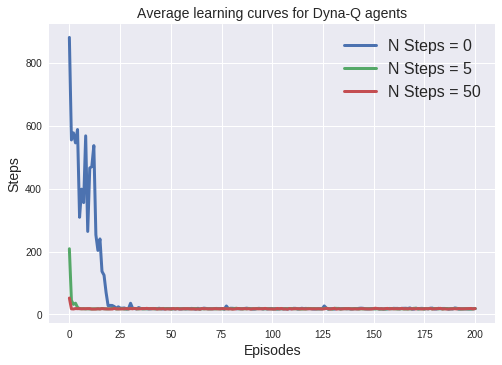

In [57]:
model = Model()

left_open_maze = BlockedMaze('left')

legend = []

for planning_nstep in planning_nsteps:
  print("Running Agent For Planning n-steps: %d" % planning_nstep)
  total_steps = np.zeros((params['runs'], params['episodes']))
  for run in range(params['runs']):
    dynaQ = DynaQ(params, model, left_open_maze.action_space, left_open_maze.observation_space, np.random)

    for episode in range(params['episodes']):
      obs = left_open_maze.reset()
      initial_state = obsv2state(obs)
      steps, totalreward = dynaQ.run(initial_state, left_open_maze, planning_nstep)
      total_steps[run, episode] = steps
  episodes_index = np.linspace(0, params['episodes'], params['episodes'], endpoint=True)    
  temp = "N Steps = {:}".format(planning_nstep)
  legend.append(temp)
  plt.plot(episodes_index, np.average(total_steps, axis=0), linewidth=3)
  
plt.xlabel("Episodes", fontsize=14)
plt.ylabel("Steps", fontsize=14)
plt.title("Average learning curves for Dyna-Q agents", fontsize=14)
plt.legend(legend, prop={'size': 16}, loc='upper right', fancybox=True, framealpha=0.5)
print("The figure below shows the average learning curves for Dyna-Q agents varying in their number of planning steps (n) per real step.")
print("           ")
print("           ")
plt.show()

**Results & Analysis:** As expected, the non-planning agent i.e. planning with nsteps = 0 took approximately 25 episodes to reach the optimal performance, whereas the agent planning with n-steps = 5 and 50 took approximately 5 and 2 episodes roughly. It is observed here planning with n steps help learn faster as opposed to direct learning.

# **Blocking Maze Experiment**

---



For Planning n-steps: 10



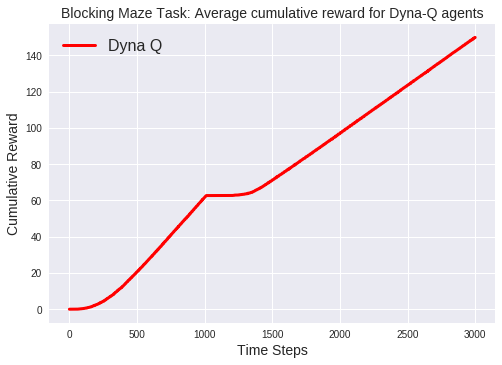

In [58]:
model = Model()

left_open_maze = BlockedMaze('left')
right_open_maze = BlockedMaze('right')

planning_nsteps = 10
print("For Planning n-steps: %d" % planning_nsteps)
print("")

params['alpha'] = 0.7
params['runs'] = 20
params['episodes'] = 1000
params['max_steps'] = 3000
 
rewards = np.zeros((params['runs'], params['max_steps']))

for run in range(params['runs']):
  cumulativereward = 0
  timesteps = 0
  last_steps = 0
  dynaQ = DynaQ(params, model, right_open_maze.action_space, left_open_maze.observation_space, np.random.RandomState(run))
  for episode in range(params['episodes']):
    if timesteps <= 1000:
      maze = right_open_maze
    elif timesteps > 1000:
      maze = left_open_maze 

    obs = maze.reset()
    initial_state = obsv2state(obs)
    steps, totalreward = dynaQ.run(initial_state, maze, planning_nsteps)
    timesteps += steps
   
    if timesteps > params['max_steps']:
      break
     
    cumulativereward += totalreward
    rewards[run, timesteps:] = cumulativereward
   

plot(range(0, params['max_steps']), np.average(rewards, axis=0), "Time Steps", "Cumulative Reward", 
       ["Dyna Q"], "Blocking Maze Task: Average cumulative reward for Dyna-Q agents")

**Results & Analysis:** Similar to the experiments in the Sutton book, we observe that the first part of the graph indicates that  Dyna agents found the short path within 1000 steps. However, when the environment changed, the graphs become flat, "indicating a period during which the agents obtained no reward because they were wandering around behind the barrier. After a while, however, they were able to find the new opening and the new optimal behavior.""

# Shortcut Maze Experiment

For Planning n-steps: 50
       


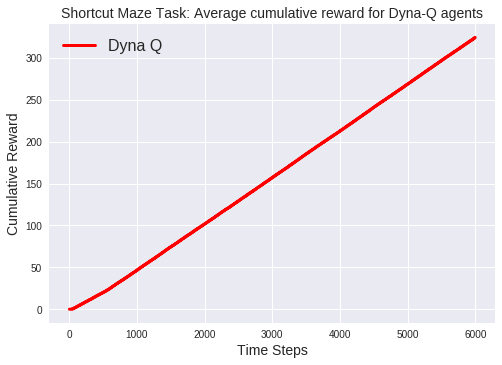

In [59]:
model = Model()

left_open_maze = BlockedMaze('left')
both_open_maze = BlockedMaze('both')

planning_nsteps = 50
print("For Planning n-steps: %d" % planning_nsteps)
print("       ")

params['alpha'] = 0.7
params['runs'] = 5
params['episodes'] = 1000
params['max_steps'] = 6000
 
rewards = np.zeros((params['runs'], params['max_steps']))

for run in range(params['runs']):
  cumulativereward = 0
  timesteps = 0
  last_steps = 0
  dynaQ = DynaQ(params, model, left_open_maze.action_space, left_open_maze.observation_space, np.random.RandomState(run))
  for episode in range(params['episodes']):
    if timesteps <= 3000:
      maze = left_open_maze
    elif timesteps > 3000:
      maze = both_open_maze 

    obs = maze.reset()
    initial_state = obsv2state(obs)
    steps, totalreward = dynaQ.run(initial_state, maze, planning_nsteps)
    timesteps += steps
    
    if timesteps > params['max_steps']:
      break
      
    cumulativereward += totalreward
    rewards[run, timesteps:] = cumulativereward
   

plot(range(0, params['max_steps']), np.average(rewards, axis=0), "Time Steps", "Cumulative Reward", 
      ["Dyna Q"], "Shortcut Maze Task: Average cumulative reward for Dyna-Q agents")

# Read about Lin’s experience replay. How is the above deterministic model update in Dyna-Q related to experience replay ? 


Traditionally, in a model-free set up, reinforcement learning algorithms learn by interacting with the environment directly. In doing so, they throw away all the data they interact with. Model-based RL algorithms and experience replay buffers do not throw away this data and instead use this experience in different ways.



The primary similarity between Lin's experience replay and the determinstic model update in Dyna-Q is that both approaches reuse past experiences. Interacting with the environment is time consuming and costly. Lin et al. defined 'experience' as a quadruple, (s,a,s',r). 'Experience replay' was then defined as remembering past experiences by recording and storing such experiences, and replaying these experiences in a temporal order. 



Similarly, the determinstic model update in Dyna-Q algorithm records and maintains an action model. In Dyna-Q, the model M is similar to an action model as defined in Lin et al. Model M is a function from a state and action (s,a), to the next state and immediate reward (a,r). Dyna-Q builds a model to simulate and generate new data (Sutton, 1990; Sutton et al., 2008). This method, however, induces both extra computation cost and modeling error for the data. Experience replay presents the stored experiences to the agent as if it were to experience them again every time it is used. 



---